# Introduction

Goal is to predict employee retention and understand its main drivers

Assume, for each company, that the headcount starts from zero on 2011/01/23. 




# Loading Libraries and Datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source



pd.set_option('display.width', 350)

data = pd.read_csv("/kaggle/input/employee-retention/employee_retention.csv")
print(
    data.head(20),
    '\n',
    '\n',
    data.shape)

    employee_id  company_id              dept  seniority    salary   join_date   quit_date
0       13021.0           7  customer_service         28   89000.0  2014-03-24  2015-10-30
1      825355.0           7         marketing         20  183000.0  2013-04-29  2014-04-04
2      927315.0           4         marketing         14  101000.0  2014-10-13         NaN
3      662910.0           7  customer_service         20  115000.0  2012-05-14  2013-06-07
4      256971.0           2      data_science         23  276000.0  2011-10-17  2014-08-22
5      509529.0           4      data_science         14  165000.0  2012-01-30  2013-08-30
6       88600.0           4  customer_service         21  107000.0  2013-10-21         NaN
7      716309.0           2  customer_service          4   30000.0  2014-03-05         NaN
8      172999.0           9          engineer          7  160000.0  2012-12-10  2015-10-23
9      504159.0           1             sales          7  104000.0  2012-06-12         NaN

# Descriptive Statistics

In [2]:
print(data.describe(),
     '\n',
     '\n',
      data.dtypes)

#Turn dates into date format
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])

print(data.describe(),
     '\n',
     '\n',
      data.dtypes)

         employee_id    company_id     seniority         salary
count   24702.000000  24702.000000  24702.000000   24702.000000
mean   501604.403530      3.426969     14.127803  138183.345478
std    288909.026101      2.700011      8.089520   76058.184573
min        36.000000      1.000000      1.000000   17000.000000
25%    250133.750000      1.000000      7.000000   79000.000000
50%    500793.000000      2.000000     14.000000  123000.000000
75%    753137.250000      5.000000     21.000000  187000.000000
max    999969.000000     12.000000     99.000000  408000.000000 
 
 employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object
         employee_id    company_id     seniority         salary                      join_date                      quit_date
count   24702.000000  24702.000000  24702.000000   24702.000000                          24702                         

# Feature Engineering

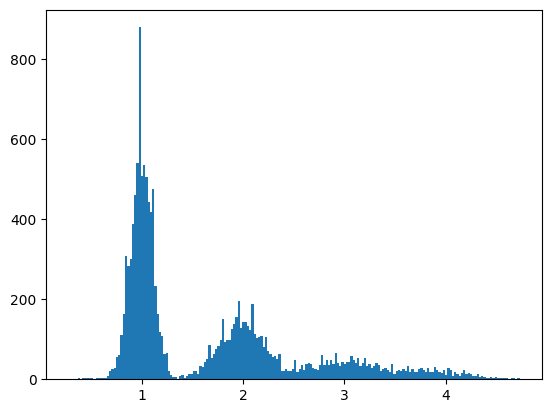

In [3]:
data['employment_length_day'] = (data['quit_date'] - data['join_date']).dt.days
data['employment_length_year'] = (data['quit_date'] - data['join_date']).dt.days / 365

plt.hist(data['employment_length_year'].dropna(),bins = 200)
plt.show()

A lot of people's employment length is 1 or 2 years. They quit after the anniversary. 1 year quits are by far the most common. Let's investigate.



In [4]:
# Create binary class: users quit within 13 months or not
data = data[data['join_date'] <datetime.strptime("2015/12/13", "%Y/%m/%d") - timedelta(days=(365+31))]
data['quit_in_13mo'] = np.where((data['employment_length_day']>396) | (np.isnan(data['employment_length_day'])), 0, 1)

# Decision Tree

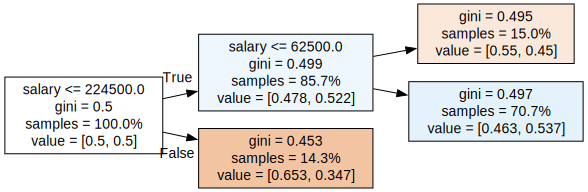

In [5]:
#print(data.head())
data_dummy = pd.get_dummies(data[['company_id','dept','seniority','salary','quit_in_13mo']],drop_first = True)
X = data_dummy.drop('quit_in_13mo', axis=1)
y = data['quit_in_13mo']

tree = DecisionTreeClassifier(max_depth = 4,
                              min_samples_leaf = 30,
                              class_weight = "balanced",
                              min_impurity_decrease = 0.001
                             )
tree.fit(X,y)

plt_config = export_graphviz(tree,
                             feature_names = X.columns,
                             proportion = True,
                             rotate = True,
                             filled = True
                            )

plt = Source(plt_config)
plt


**Observations**

Salary is the most important in preicting whether one quits within 13 months

Those with low salary <=62,500 and with high salary >= 224,500 are not likely to quit within 13 mo.

Those in the middle (betweeen 62,500 and 224,500) are the ones quitting fast

Let's plot a graph to confirm

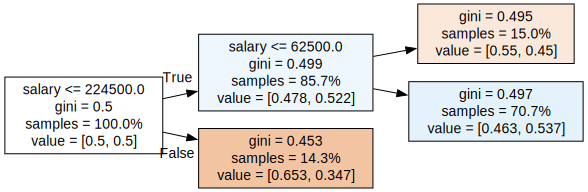

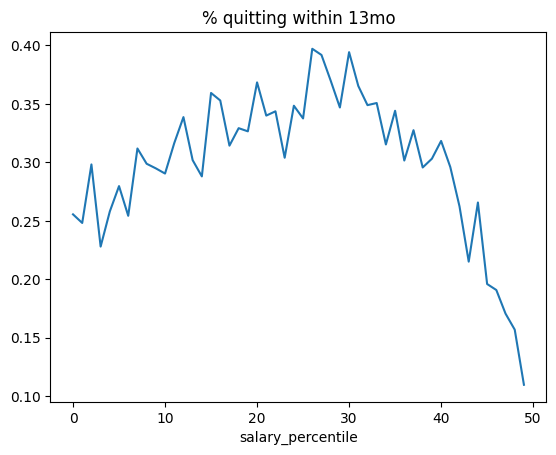

In [6]:
data['salary_percentile'] = pd.qcut(
                                    data['salary'],
                                    q = 50,
                                    labels = False)

data.groupby('salary_percentile')['quit_in_13mo'].mean().plot(title = "% quitting within 13mo")
plt

# Conclusion and Recommendation

1. Employees whose salary is in the MIDDLE range

They are likely to quit after 13 mos. Can we find more data related to those people, like from their exit interviews? 
   
They prob quit becase something is wrong within their short tenure, but they stuck it out until 1 year to quit. What are they unhappy with? Is our pay not competitive with the market and those employees got better paid position else where? Or is it they don't see advancement/promotion in the job?

This is the biggest hit to improve employee retention

